# Use Python <3.10

This package heavily utilizes the pyMuellerMat package that makes Mueller matrices from "system dictionaries" detailing the instrument configuration. Make sure to clone the physical_models branch of pyMuellerMat at https://github.com/maxwellmb/pyMuellerMat/.

In [1]:
import sys
import numpy as np
from pathlib import Path
from vampires_calibration.instruments import fit_CHARIS_Mueller_matrix_by_bin_pickoff
from vampires_calibration.csv_tools import write_fits_info_to_csv,read_csv,read_csv_physical_model_all_bins
from vampires_calibration.fitting import *
from vampires_calibration.utils import *
from vampires_calibration.plotting import plot_data_and_model
from pyMuellerMat.physical_models.charis_physical_models import *
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
# Plot settings that I like
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})

# Step 1: Write FITS Info to CSV

In [9]:
# Get paths to both processed and raw data 
# Make sure these directories have cubes with corresonding numbers
cube_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_3/cubes/no_pick'
raw_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Raw_3/internal-cal/no_pick'

# Write all bins to csvs
for bin in range(0,22):
   csv_filepath = f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv'
   #write_fits_info_to_csv(cube_dir, raw_dir, csv_filepath,bin)



CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin0_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin1_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin2_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin3_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin4_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin5_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin6_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/D

# Step 2 (Optional): Plot Your Data With the Original Model 

In [2]:
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# I have bin 15 here, I would recommend using a bin in the middle to get a good idea of goodness of
# fit, bin zero and lower bins can be finicky
filepath = Path('datacsvs/csvs_pickoff/bin4_pick.csv')
# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath,mode='wavelength')
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  128
[ 19616456.68436867  20781810.2751221  -21634659.31802332
  22965669.07356203  15043631.49511406  20861568.37476805
 -17127539.54345465  22809185.36560488   1054475.85710156
  21523306.88653266]
Interleaved Stds
Length:  128
[4558.70708372 4558.70708372 4792.25094017 4792.25094017 4567.44659244
 4567.44659244 4775.89628924 4775.89628924 4639.32181321 4639.32181321]
Configuration List
Length:  64
[{'hwp': {'theta': 0.0, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 45.0, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 11.25, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 56.25, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 22.5, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta':

In [3]:

# Define wavelength bins for CHARIS
wavelength_bin = 2
wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])

# Loading in past fits 

offset_imr = 0.13214 # derotator offset
offset_hwp = -0.99287 # HWP offset
offset_cal = 0.49797 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# using MCMC results for physical model as a starting point
system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
                "pickoff" : {
                    "type" : "diattenuator_retarder_function",
                    "properties" : {"phi": 0, "delta_theta":0,"epsilon":0.6 },
                    "tag": "internal",
                },      
                "image_rotator" : {
                    "type" : "SCExAO_IMR_function",
                    "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": 264.8, "theta": imr_theta, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "two_layer_HWP_function",
                    "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2":1.72, "w_MgF2": 1.34, "theta":hwp_theta, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[0.79823319 0.7981126  0.01387454 0.        ]
 [0.79823319 0.7981126  0.01387454 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


In [4]:
from vampires_calibration.utils import process_dataset
import matplotlib.pyplot as plt
interleaved_vals, errs, configs = read_csv_physical_model_all_bins('datacsvs/csvs_nopickoff')
inter_2, errs2,configs2 = read_csv_physical_model_all_bins('datacsvs/csvs_pickoff')
# interleaved_vals = process_dataset(interleaved_vals)
# inter_2 = process_dataset(inter_2)
diffsnopick = interleaved_vals[::2]
diffspick = inter_2[::2]


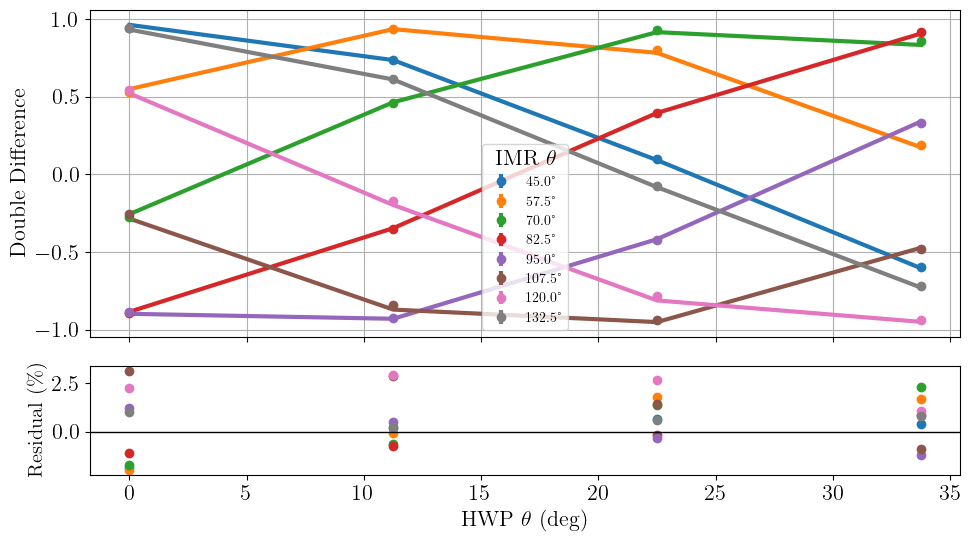

In [5]:

# Get our model retardances from Joost t Hart physical models

p = [0, 0]


# Define what is in the p list

system_parameters = [['pickoff', 'phi'], ['pickoff', 'delta_theta']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities)

# Plot the modeled and observed values

fig, ax = plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[4],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1931.png',bbox_inches='tight', dpi=600)




# Step 3: Fit for Retardances

In [2]:
# Test fitting with the wavelength bin we plotted earlier

error, fig2, ax2,sres = fit_CHARIS_Mueller_matrix_by_bin_pickoff(filepath, 4, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dicts_with_pickoff/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1329.png',bbox_inches='tight', dpi=600)



NameError: name 'filepath' is not defined

Looks like our model improved! Note that the Joost't Hart paper used a more elaborate physical model, which I will incorporate later. These fits are a good starting point for more detailed models. Now we can fit for all bins and collect the errors.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2975e-01                                    6.61e-01    
       1             13         3.2975e-01      0.00e+00       0.00e+00       6.61e-01    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 3.2975e-01, final cost 3.2975e-01, first-order optimality 6.61e-01.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.382e-02  1.433e-01 ... -3.584e-02  1.445e-01]
           x: [ 1.000e-10  1.000e-10  1.000e-10  0.000e+00]
        cost: 0.32974680509011794
         jac: [[-5.344e-03 -8.964e-01  8.936e-02  0.000e+00]
               [-1.629e-04 -2.421e-02 -3.871e-04  0.000e+00]
               ...
               [-9.006e-03 -6.649e-01 -6.951e-01  0.000e+00]
               [-2.204e-04 -2.680e-02 -6.478e-03  0.000e+00]]
        grad: [-9.540e-04 -3.883e-02 -1.052e-01  0.000e+00]
  op

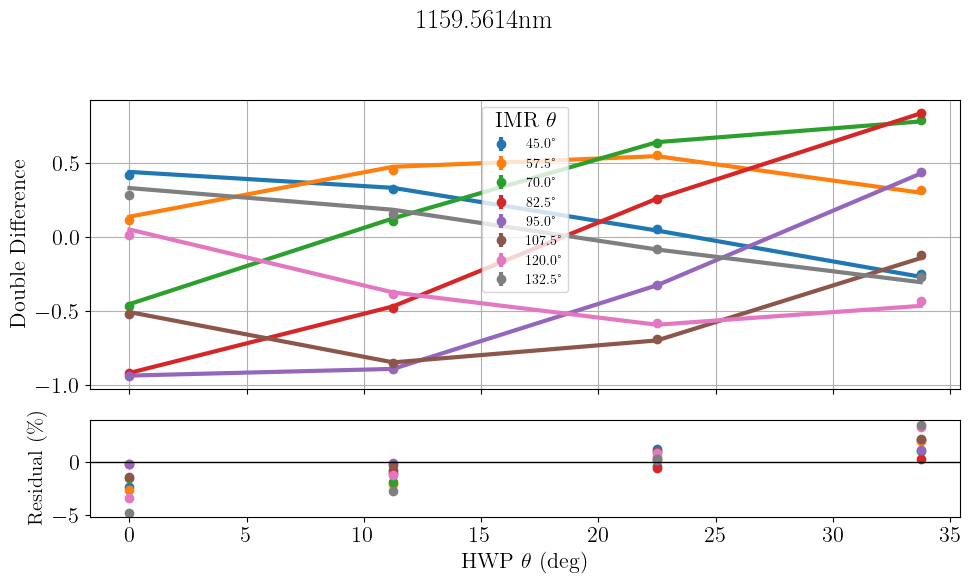

Updated Mueller Matrix:
[[ 0.34414633  0.34414339 -0.00142173  0.        ]
 [-0.34414633 -0.34414339  0.00142173  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 1.9862413821000096
Residuals range: -4.7785444293183055 3.5840313631684104
Error: [0.00033625 0.02941206 0.03436554 0.        ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4117e-02                                    5.17e-01    
       1              2         2.4115e-02      2.05e-06       2.51e-05       5.12e-01    
       2              3         2.4111e-02      4.07e-06       5.01e-05       5.09e-01    
       3              4         2.4103e-02      8.08e-06       1.00e-04       5.03e-01    
       4              5         2.4087e-02      1.59e-05       2.01e-04       4.91e-01    
       5              6         2.4056e-02      3.06e-05       4.01e-04       4.67e

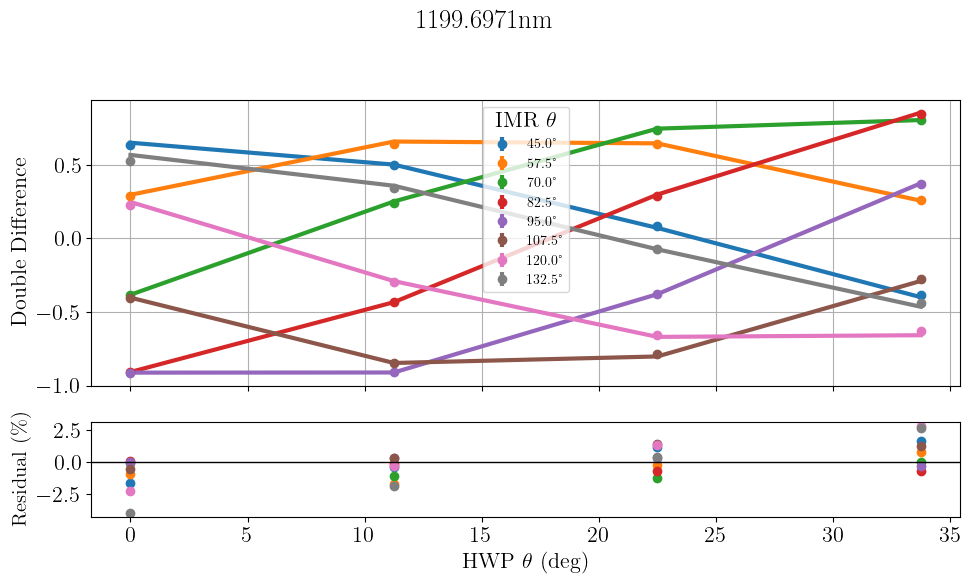

Updated Mueller Matrix:
[[ 0.38253909  0.38253583 -0.00158034  0.        ]
 [-0.3816318  -0.38162854  0.00157659  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 1.4444733426692509
Residuals range: -3.9429763644659417 2.8091064769567
Error: [687398.59124668  12729.25718261   3367.91122042 729511.17659682]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.9781e-02                                    1.14e+00    
       1             13         6.9781e-02      0.00e+00       0.00e+00       1.14e+00    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 6.9781e-02, final cost 6.9781e-02, first-order optimality 1.14e+00.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 3.463e-02  5.804e-02 ... -1.304e-02  5.663e-02]
           x: [ 1.000e-10  1.000e-

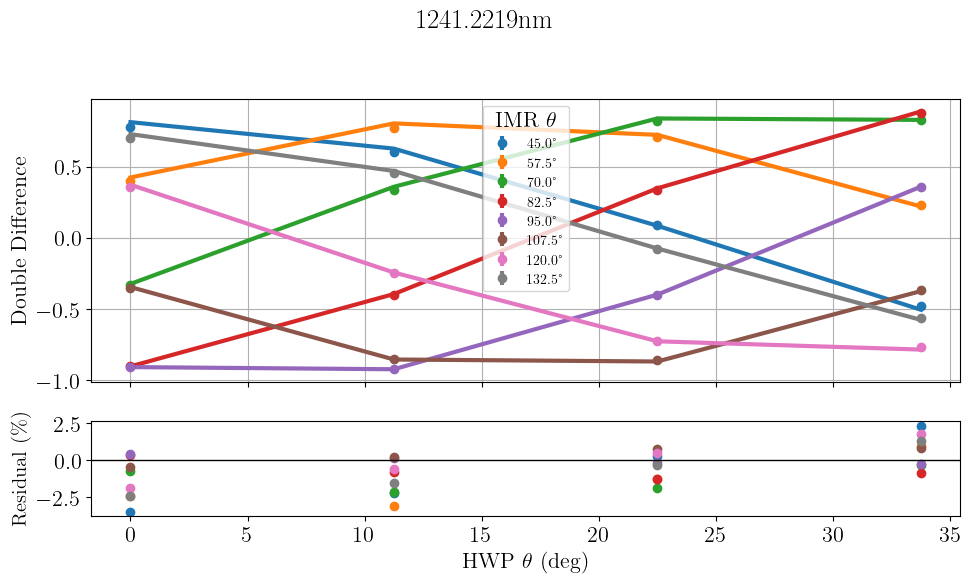

Updated Mueller Matrix:
[[ 0.40898397  0.40898048 -0.00168959  0.        ]
 [-0.4086772  -0.40867371  0.00168832  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 1.5616280022462663
Residuals range: -3.463491191494242 2.333710853979781
Error: [0.00020801 0.02153809 0.01499673 0.        ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.0298e-02                                    1.24e+00    
       1             13         8.0298e-02      0.00e+00       0.00e+00       1.24e+00    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 8.0298e-02, final cost 8.0298e-02, first-order optimality 1.24e+00.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 3.490e-02  5.896e-02 ... -8.329e-03  6.719e-02]
           x: [ 1.000e-10  1.000e-10  1.000e-10  0.00

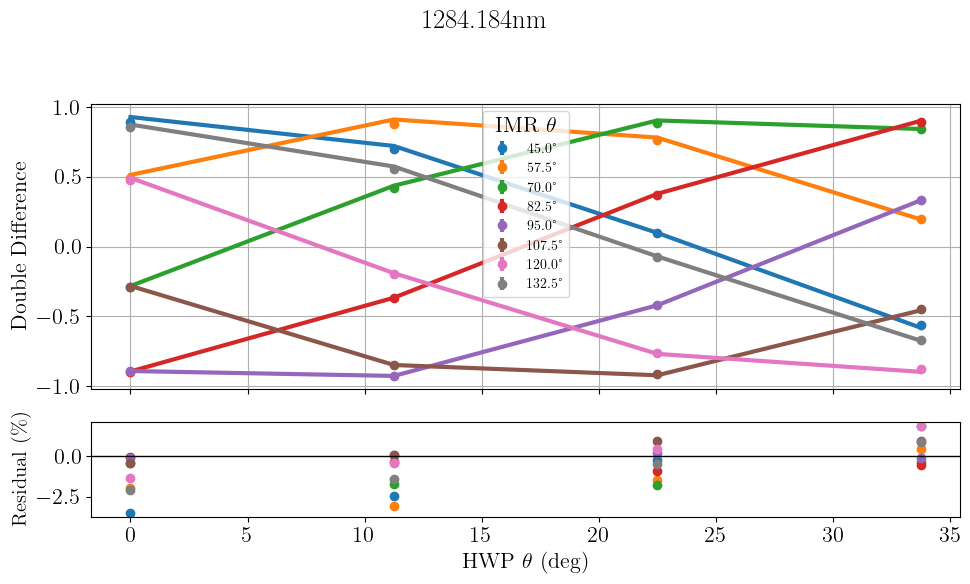

Updated Mueller Matrix:
[[ 0.42861217  0.42860851 -0.00177068  0.        ]
 [-0.42774737 -0.42774372  0.0017671   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 1.4431452693806215
Residuals range: -3.48994362205282 1.8277467501350628
Error: [0.00030811 0.03687181 0.01555961 0.        ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.4123e-02                                    1.00e+00    
       1             13         6.4123e-02      0.00e+00       0.00e+00       1.00e+00    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 6.4123e-02, final cost 6.4123e-02, first-order optimality 1.00e+00.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.806e-02  4.955e-02 ... -1.434e-02  5.651e-02]
           x: [ 1.000e-10  1.000e-10  1.000e-10  0.00

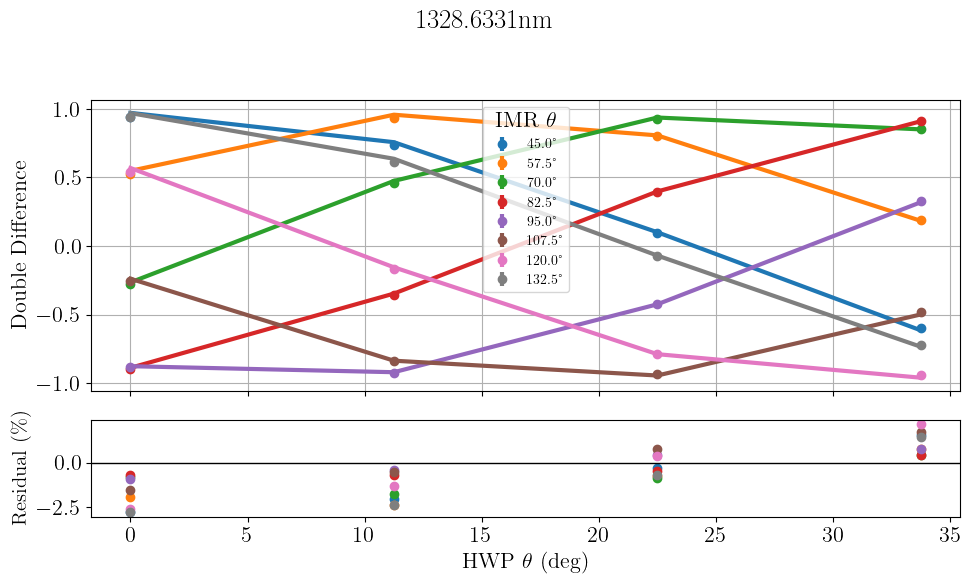

Updated Mueller Matrix:
[[ 0.43585737  0.43585365 -0.00180061  0.        ]
 [-0.43463752 -0.43463381  0.00179557  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 1.5360245161595458
Residuals range: -2.8058382306808767 2.170108841208986
Error: [0.00052563 0.07770483 0.01181343 0.        ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.6768e-02                                    1.67e+00    
       1             13         8.6768e-02      0.00e+00       0.00e+00       1.67e+00    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 8.6768e-02, final cost 8.6768e-02, first-order optimality 1.67e+00.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.302e-03  6.193e-02 ... -8.854e-03  6.853e-02]
           x: [ 1.000e-10  1.000e-10  1.000e-10  0.0

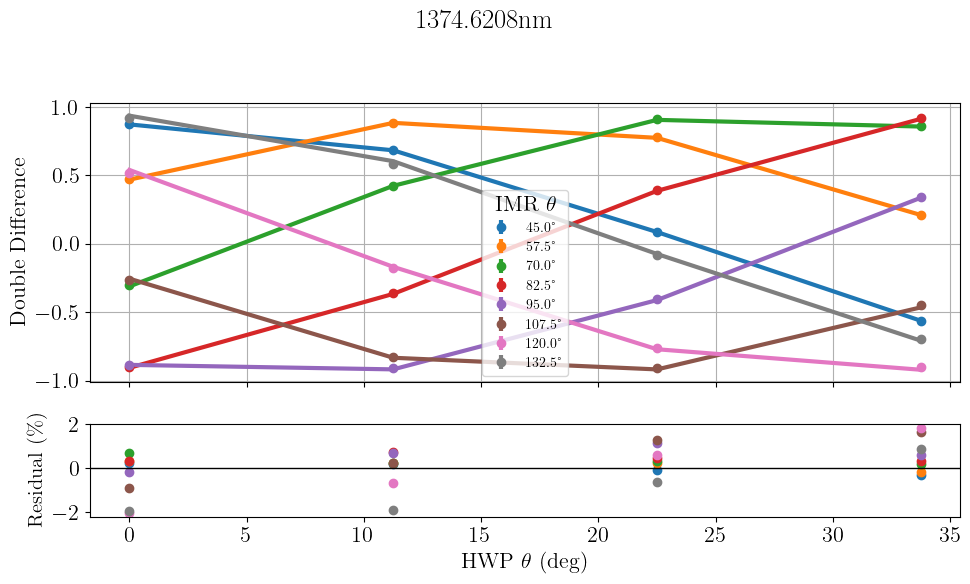

Updated Mueller Matrix:
[[ 0.41848248  0.41847891 -0.00172883  0.        ]
 [-0.41759049 -0.41758693  0.00172514  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.9487988410738571
Residuals range: -2.023479330980244 1.822114190273112
Error: [0.00021726 0.03791101 0.01628128 0.        ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1679e-01                                    2.18e+00    
       1              2         1.1678e-01      8.63e-06       2.51e-05       2.16e+00    
       2              3         1.1676e-01      1.72e-05       5.01e-05       2.16e+00    
       3              4         1.1673e-01      3.44e-05       1.00e-04       2.16e+00    
       4              5         1.1666e-01      6.87e-05       2.01e-04       2.15e+00    
       5              6         1.1652e-01      1.37e-04       4.01e-04       2.13e+0

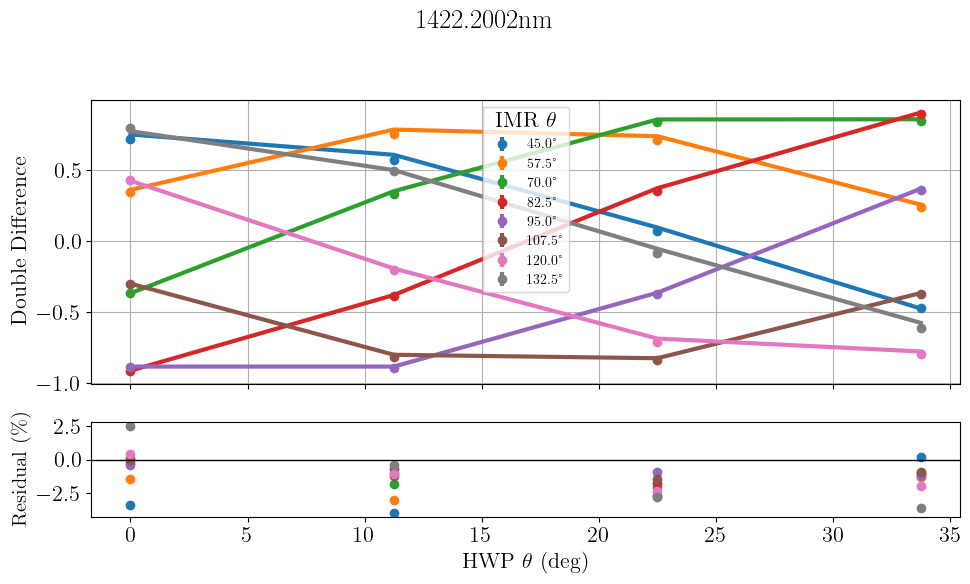

Updated Mueller Matrix:
[[ 0.37707177  0.37706855 -0.00155775  0.        ]
 [-0.37586575 -0.37586254  0.00155277  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 1.991005141328314
Residuals range: -3.9679564970797827 2.485422877283142
Error: [8.22652384e+05 7.94026311e+05 2.97671867e+04 3.54217391e+07]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.2417e-02                                    2.03e+00    
       1              2         7.2409e-02      8.06e-06       2.51e-05       2.02e+00    
       2              3         7.2392e-02      1.61e-05       5.01e-05       2.02e+00    
       3              4         7.2360e-02      3.21e-05       1.00e-04       2.01e+00    
       4              5         7.2296e-02      6.39e-05       2.01e-04       2.00e+00    
       5              6         7.2170e-02      1.27e-04       4.01e-

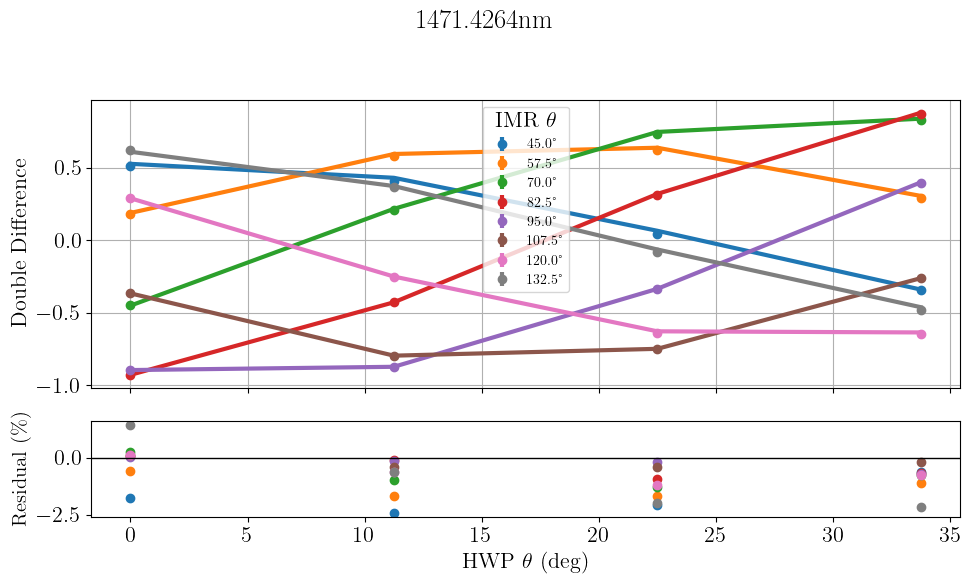

Updated Mueller Matrix:
[[ 0.34412386  0.34412093 -0.00142164  0.        ]
 [-0.34286769 -0.34286476  0.00141645  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 1.1693781498409148
Residuals range: -2.407091110887535 1.4335712979211195
Error: [  630677.52257601  1219576.97987854    24071.22837395 22734989.18016941]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.7225e-02                                    2.07e+00    
       1              2         7.7217e-02      8.20e-06       2.51e-05       2.05e+00    
       2              3         7.7200e-02      1.64e-05       5.01e-05       2.05e+00    
       3              4         7.7168e-02      3.26e-05       1.00e-04       2.04e+00    
       4              5         7.7103e-02      6.49e-05       2.01e-04       2.02e+00    
       5              6         7.6975e-02      1.28e-04

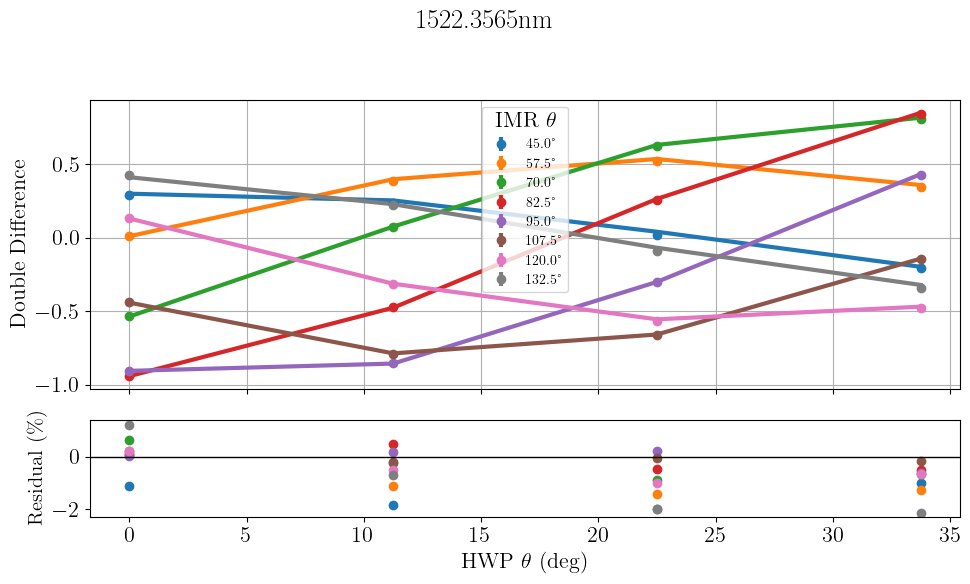

Updated Mueller Matrix:
[[ 0.30581999  0.30581738 -0.0012634   0.        ]
 [-0.30412553 -0.30412293  0.0012564   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 1.0103448789763043
Residuals range: -2.1194358361051684 1.2201047861200962
Error: [8.64889443e+05 8.56071523e+05 1.25691445e+04 3.05420863e+07]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5121e-02                                    1.50e+00    
       1              2         6.5115e-02      5.95e-06       2.51e-05       1.49e+00    
       2              3         6.5103e-02      1.19e-05       5.01e-05       1.49e+00    
       3              4         6.5079e-02      2.36e-05       1.00e-04       1.48e+00    
       4              5         6.5033e-02      4.68e-05       2.01e-04       1.46e+00    
       5              6         6.4941e-02      9.18e-05       4.01

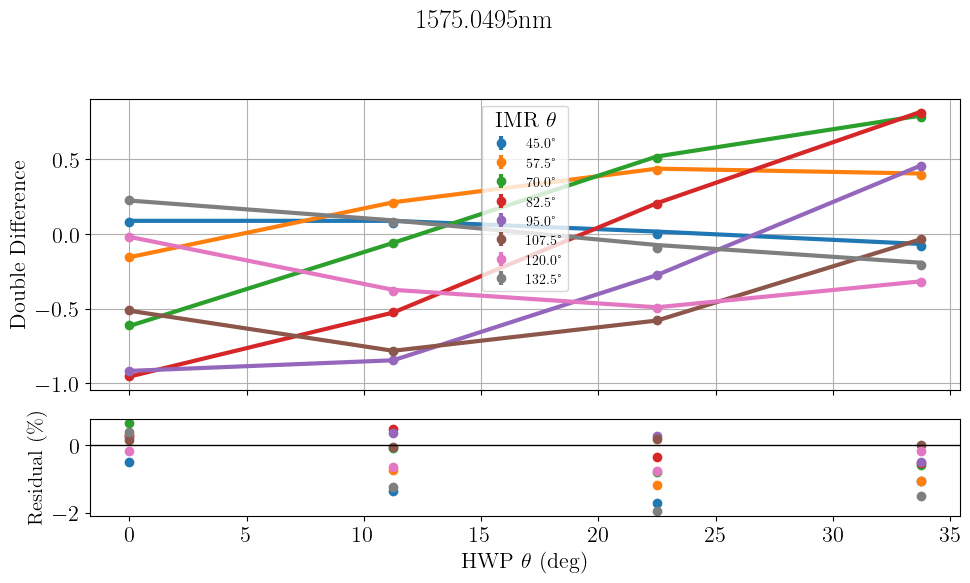

Updated Mueller Matrix:
[[ 0.27218806  0.27218574 -0.00112446  0.        ]
 [-0.2707896  -0.27078729  0.00111868  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.8486933932194684
Residuals range: -1.9645039182325927 0.636850187699757
Error: [1.63804147e+06 9.58152152e+05 9.14223558e+03 4.93244852e+07]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2003e-02                                    8.51e-01    
       1              2         4.2000e-02      3.37e-06       2.51e-05       8.44e-01    
       2              3         4.1993e-02      6.72e-06       5.01e-05       8.39e-01    
       3              4         4.1980e-02      1.33e-05       1.00e-04       8.30e-01    
       4              5         4.1954e-02      2.62e-05       2.01e-04       8.10e-01    
       5              6         4.1903e-02      5.05e-05       4.01e

/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/fitting.py:163: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


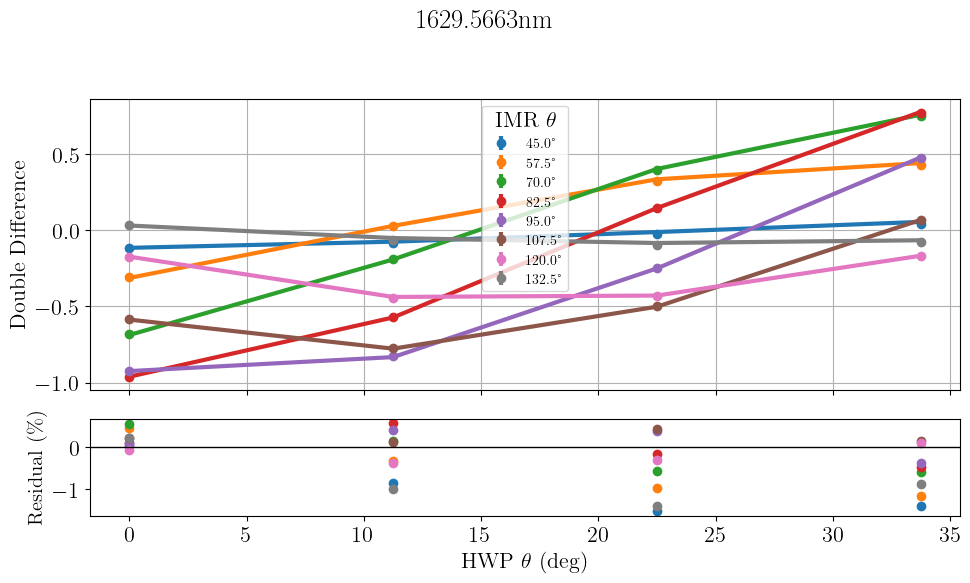

Updated Mueller Matrix:
[[ 0.24032859  0.24032654 -0.00099284  0.        ]
 [-0.23837089 -0.23836885  0.00098475  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.6968711500716329
Residuals range: -1.5325841931137905 0.5711978777880162
Error: [3.96044403e+05 8.36769338e+05 3.93750633e+03 1.58282980e+07]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7802e-02                                    4.67e-01    
       1              2         3.7800e-02      1.85e-06       2.51e-05       4.63e-01    
       2              3         3.7796e-02      3.67e-06       5.01e-05       4.58e-01    
       3              4         3.7789e-02      7.23e-06       1.00e-04       4.48e-01    
       4              5         3.7775e-02      1.40e-05       2.01e-04       4.30e-01    
       5              6         3.7749e-02      2.62e-05       4.01

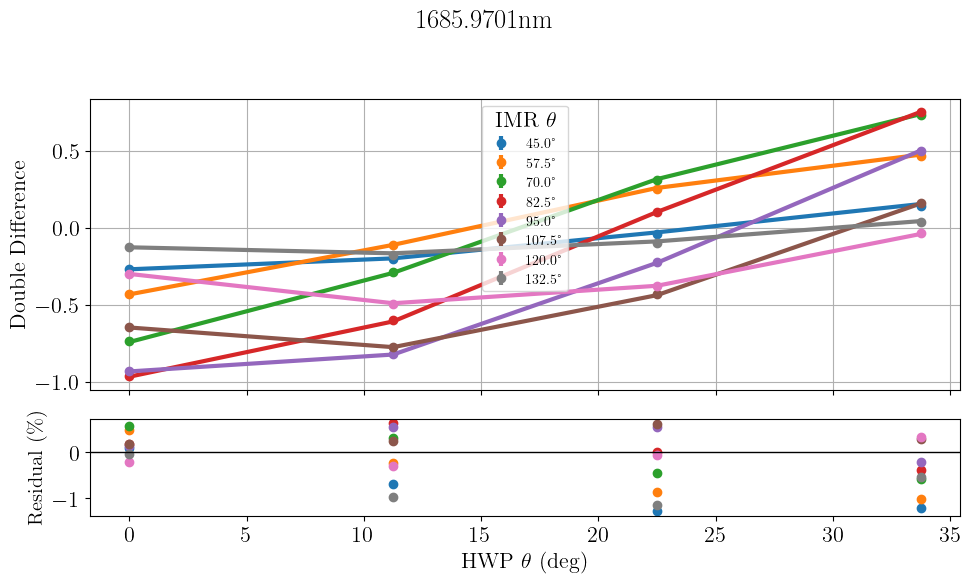

Updated Mueller Matrix:
[[ 0.21498707  0.21498524 -0.00088815  0.        ]
 [-0.21307492 -0.2130731   0.00088025  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.6243987003001791
Residuals range: -1.2943674266311138 0.6345929683800122
Error: [1066274.92963422    2036.53935216    2637.77867022 1452495.64828864]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2347e-02                                    2.49e-01    
       1              2         4.2346e-02      9.84e-07       2.51e-05       2.45e-01    
       2              3         4.2344e-02      1.94e-06       5.01e-05       2.41e-01    
       3              4         4.2341e-02      3.77e-06       1.00e-04       2.32e-01    
       4              5         4.2334e-02      7.12e-06       2.01e-04       2.14e-01    
       5              6         4.2321e-02      1.25e-05   

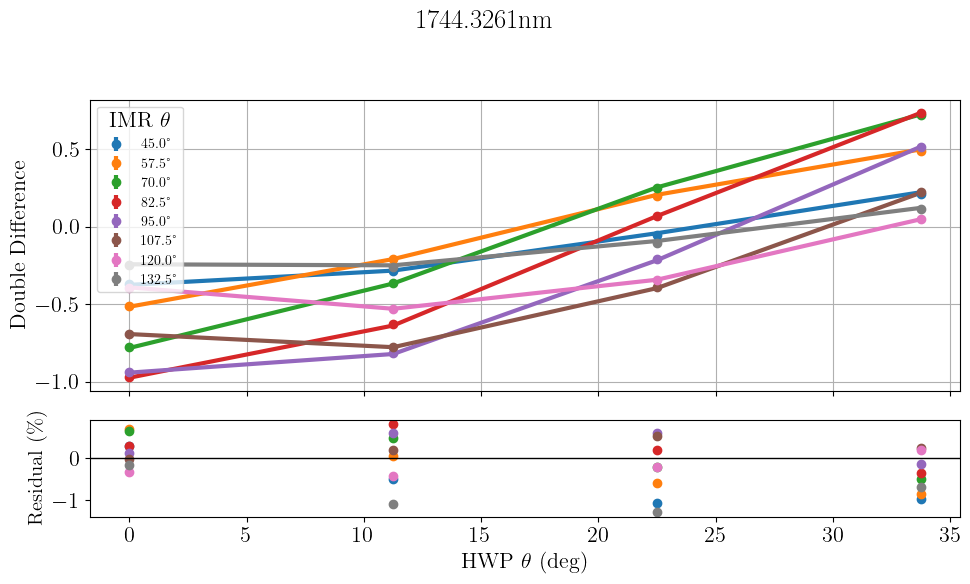

Updated Mueller Matrix:
[[ 0.1978597   0.19785801 -0.00081739  0.        ]
 [-0.19631126 -0.19630959  0.000811    0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.6072464583961894
Residuals range: -1.2920914119985234 0.8058180761548002
Error: [9.86691789e+05 3.85025419e+02 1.37626383e+03 1.18947513e+06]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1856e-02                                    6.27e-12    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 7.1856e-02, final cost 7.1856e-02, first-order optimality 6.27e-12.
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-2.777e-03  5.844e-02 ...  4.598e-03  7.768e-02]
           x: [ 1.000e-10  1.000e-10  1.000e-10  0.000e+00]
        cost: 0.07185569695241364
         jac: [[ 6.618e-03  8.791

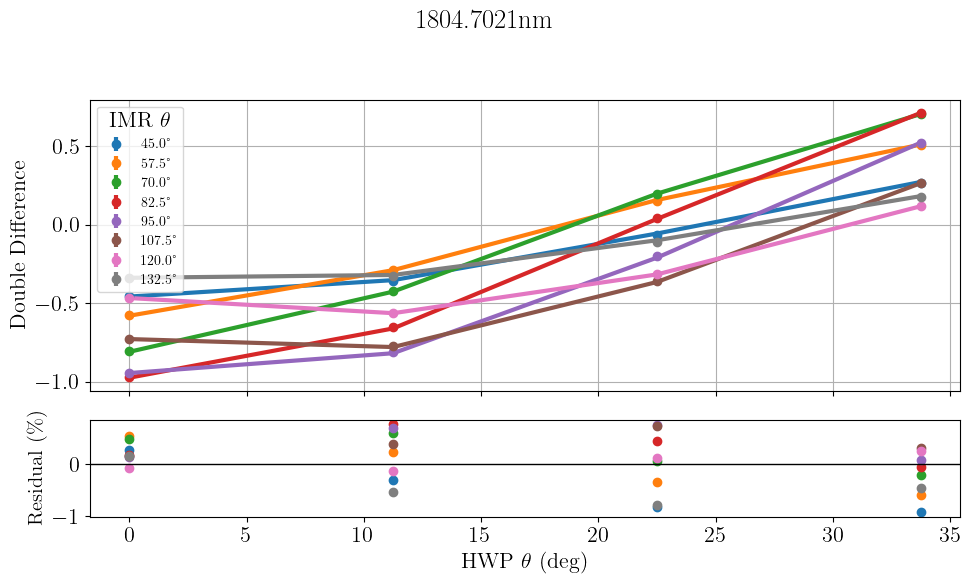

Updated Mueller Matrix:
[[ 0.18550774  0.18550615 -0.00076637  0.        ]
 [-0.18356196 -0.18356039  0.00075833  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.495662822585478
Residuals range: -0.9265414739330531 0.7729702978959381
Error: [0.00015921 0.0139729  0.01611925 0.        ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2451e-02                                    1.94e-12    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 3.2451e-02, final cost 3.2451e-02, first-order optimality 1.94e-12.
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.070e-03  4.117e-02 ...  3.967e-03  5.306e-02]
           x: [ 1.000e-10  1.000e-10  1.000e-10  0.000e+00]
        cost: 0.032450582245855154
         jac: [[ 6.394e-03  8.429e-01  1.226e-01 

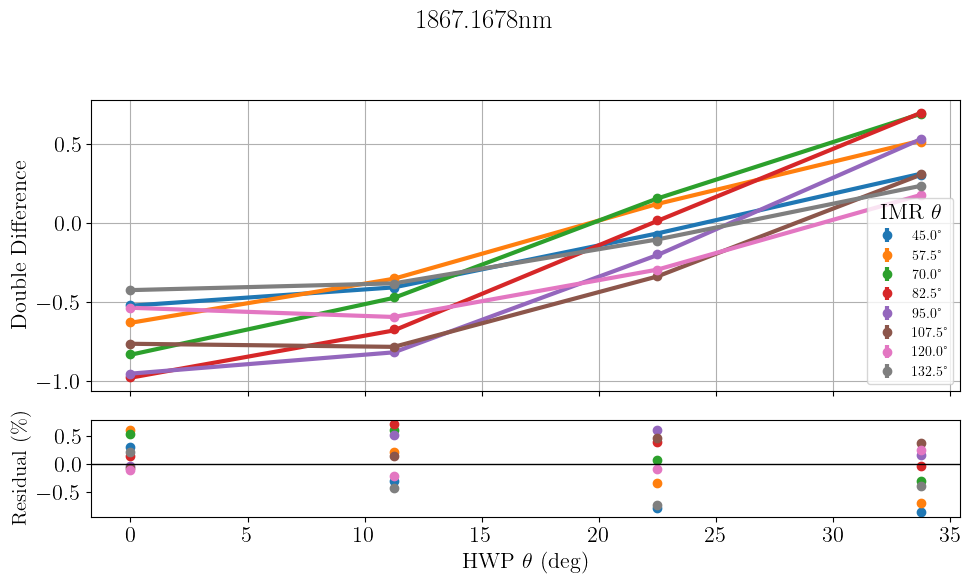

Updated Mueller Matrix:
[[ 0.17497855  0.17497705 -0.00072287  0.        ]
 [-0.17298808 -0.17298661  0.00071465  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.4604600894812451
Residuals range: -0.865046200314989 0.7197916249477743
Error: [0.00011131 0.00992611 0.01075506 0.        ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2887e-03                                    9.90e-02    
       1             13         1.2887e-03      0.00e+00       0.00e+00       9.90e-02    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 1.2887e-03, final cost 1.2887e-03, first-order optimality 9.90e-02.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-9.878e-05  2.800e-03 ...  3.672e-03  1.598e-02]
           x: [ 1.000e-10  1.000e-10  1.000e-10  0.0

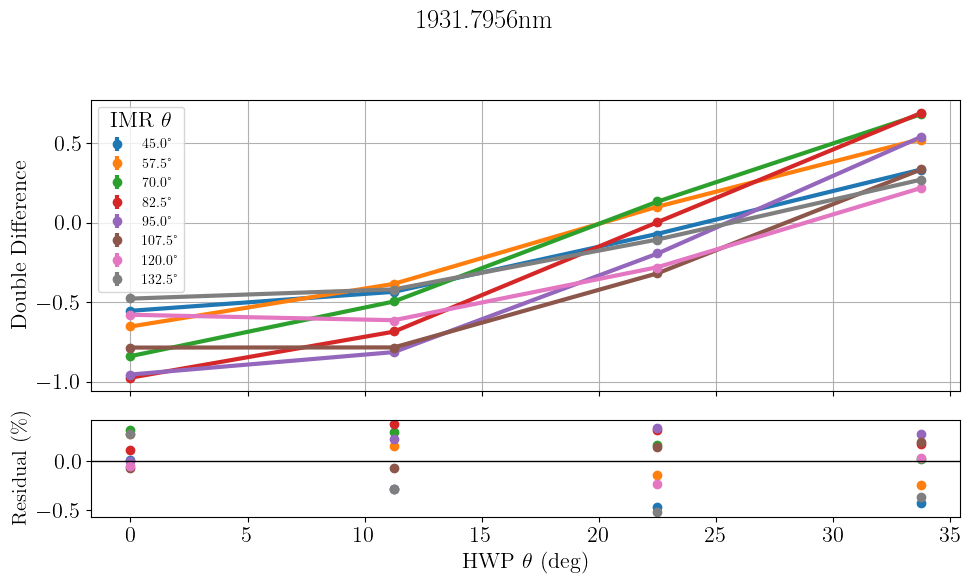

Updated Mueller Matrix:
[[ 0.17004981  0.17004836 -0.00070251  0.        ]
 [-0.1676917  -0.16769027  0.00069277  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.27448694298088017
Residuals range: -0.5251046547256433 0.3789184907595171
Error: [2.28163095e-05 2.06095290e-03 2.13582054e-03 0.00000000e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4305e-03                                    3.93e-02    
       1              2         4.4303e-03      1.53e-07       2.51e-05       3.76e-02    
       2              3         4.4300e-03      2.86e-07       5.01e-05       3.41e-02    
       3              4         4.4295e-03      4.90e-07       1.00e-04       2.73e-02    
       4              5         4.4289e-03      6.54e-07       2.01e-04       1.36e-02    
       5              6         4.4287e-03      2.18e-07       4.0

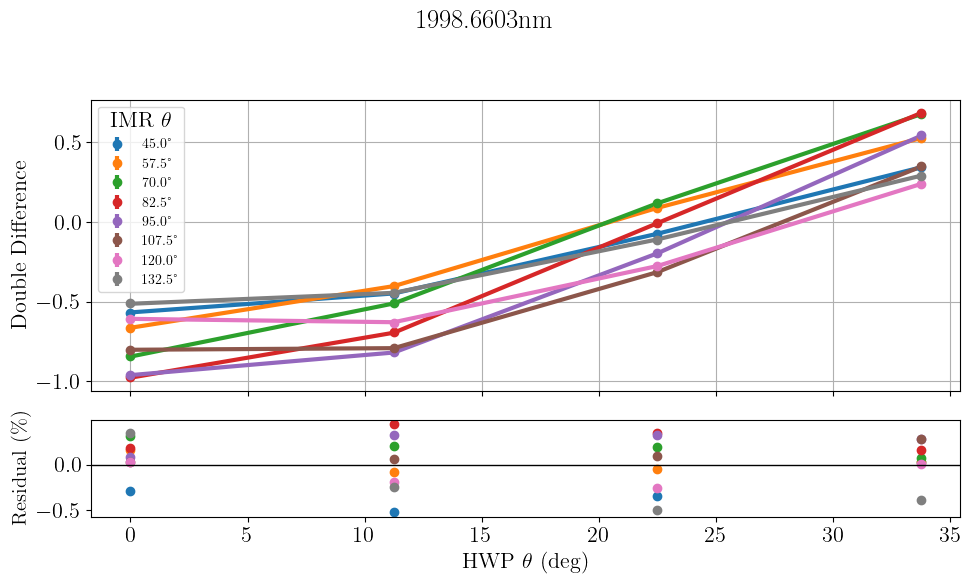

Updated Mueller Matrix:
[[ 0.16876899  0.16876755 -0.00069722  0.        ]
 [-0.16711237 -0.16711095  0.00069037  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.2733730804946943
Residuals range: -0.5271361854692174 0.4482411514039484
Error: [2.72432681e+05 2.18610251e+03 4.97915704e+01 2.89214454e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0271e-04                                    5.17e-02    
       1              2         7.0242e-04      2.87e-07       3.54e-05       4.96e-02    
       2              3         7.0189e-04      5.33e-07       7.09e-05       4.48e-02    
       3              4         7.0099e-04      9.01e-07       1.42e-04       3.51e-02    
       4              5         6.9984e-04      1.15e-06       2.84e-04       1.57e-02    
       5              6         6.9956e-04      2.89e-07       5.67

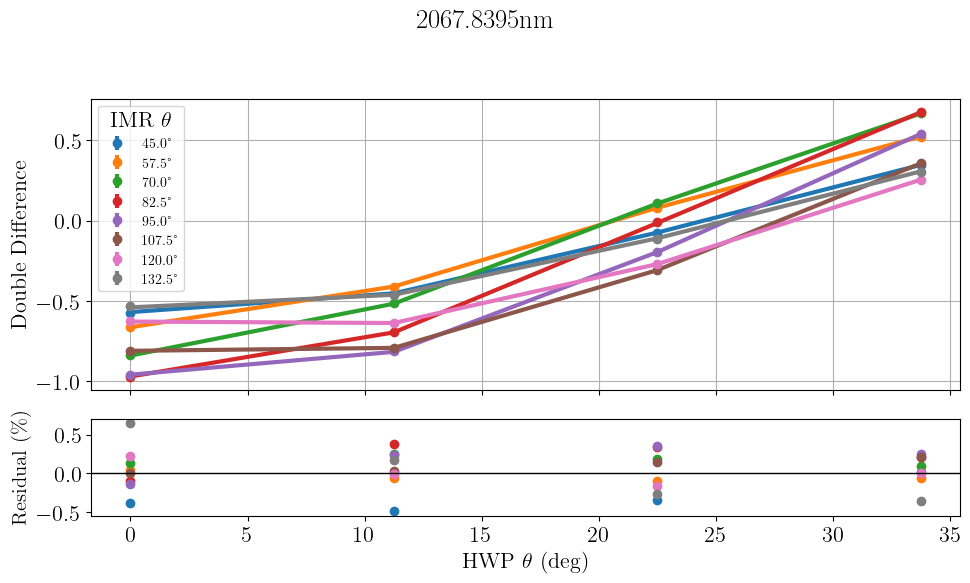

Updated Mueller Matrix:
[[ 0.16911223  0.16911079 -0.00069863  0.        ]
 [-0.16587853 -0.16587711  0.00068527  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.26443027502822997
Residuals range: -0.49298406155271834 0.6498380679415874
Error: [1.50559887e+05 1.08407601e+03 1.01321931e+02 1.15497685e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5727e-04                                    4.56e-02    
       1              2         5.5701e-04      2.55e-07       3.54e-05       4.39e-02    
       2              3         5.5655e-04      4.68e-07       7.09e-05       3.91e-02    
       3              4         5.5577e-04      7.72e-07       1.42e-04       2.93e-02    
       4              5         5.5489e-04      8.85e-07       2.84e-04       9.87e-03    
       5              6         5.5477e-04      1.17e-07       5.

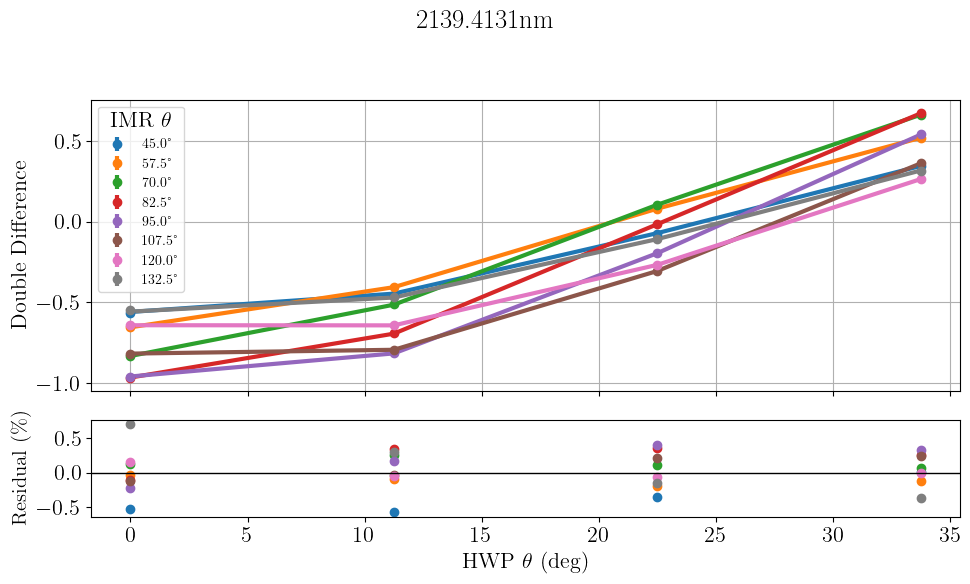

Updated Mueller Matrix:
[[ 0.17103197  0.17103051 -0.00070656  0.        ]
 [-0.16782366 -0.16782223  0.00069331  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.2906673962876331
Residuals range: -0.5754632715088377 0.7047232246262141
Error: [88528.79248849  1156.25405671   114.01967848 85342.68214836]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2765e-02                                    2.14e-02    
       1              2         1.2765e-02      1.25e-07       3.54e-05       2.09e-02    
       2              3         1.2765e-02      2.09e-07       7.09e-05       1.61e-02    
       3              4         1.2765e-02      2.56e-07       1.42e-04       6.55e-03    
       4              5         1.2765e-02      5.28e-08       2.84e-04       5.59e-05    
       5              6         1.2765e-02      5.09e-09       6.10

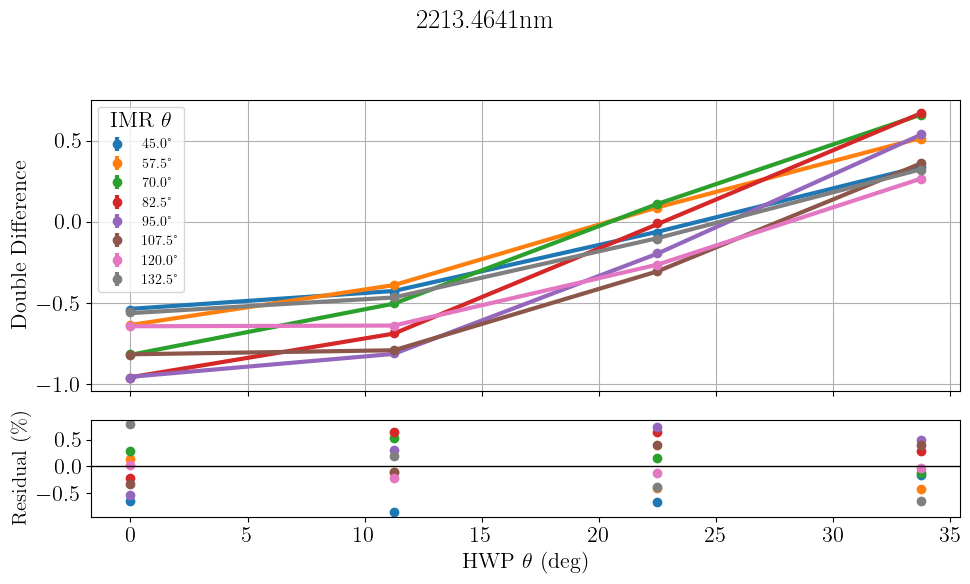

Updated Mueller Matrix:
[[ 0.17513151  0.17513002 -0.0007235   0.        ]
 [-0.170118   -0.17011655  0.00070279  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.4625343362030505
Residuals range: -0.8593097131732748 0.7870111275372125
Error: [733161.3689421    7988.5879408    2119.19601283 472192.76114663]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1626e-04                                    3.07e-02    
       1              2         6.1609e-04      1.75e-07       3.54e-05       2.98e-02    
       2              3         6.1578e-04      3.09e-07       7.09e-05       2.50e-02    
       3              4         6.1532e-04      4.58e-07       1.42e-04       1.56e-02    
       4              5         6.1503e-04      2.91e-07       2.84e-04       6.51e-05    
       5              6         6.1502e-04      5.27e-09       

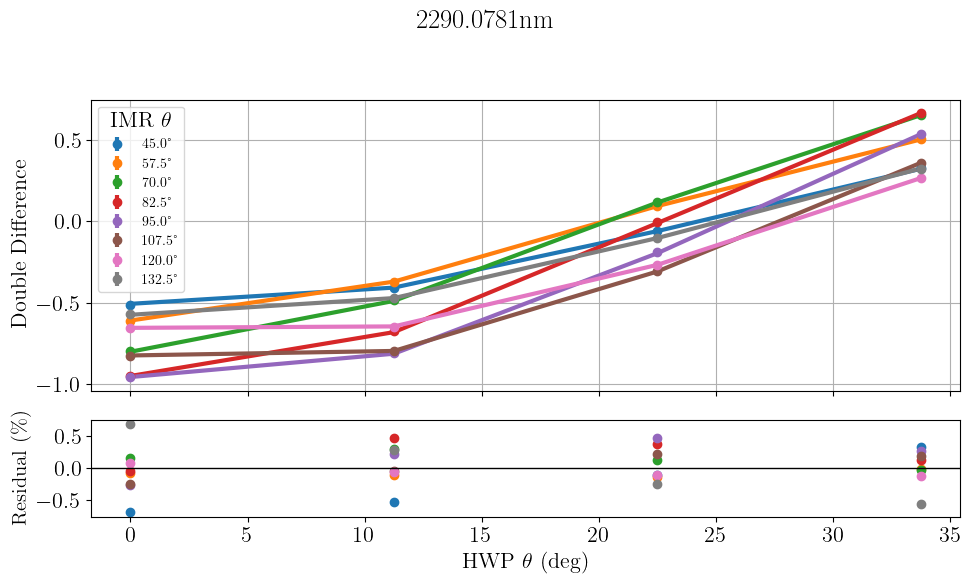

Updated Mueller Matrix:
[[ 0.18043601  0.18043447 -0.00074541  0.        ]
 [-0.17433624 -0.17433476  0.00072021  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 0.31799840277240354
Residuals range: -0.6953803642105498 0.680493215653101
Error: [100938.11814191   1586.17709448    218.11120584 113912.11420577]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2086e-01                                    1.47e-11    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 2.2086e-01, final cost 2.2086e-01, first-order optimality 1.47e-11.
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 1.728e-02 -1.199e-01 ...  2.809e-02 -1.043e-01]
           x: [ 1.000e-10  1.000e-10  1.000e-10  0.000e+00]
        cost: 0.22086069169452135
         jac: [[ 6.572e-03  8

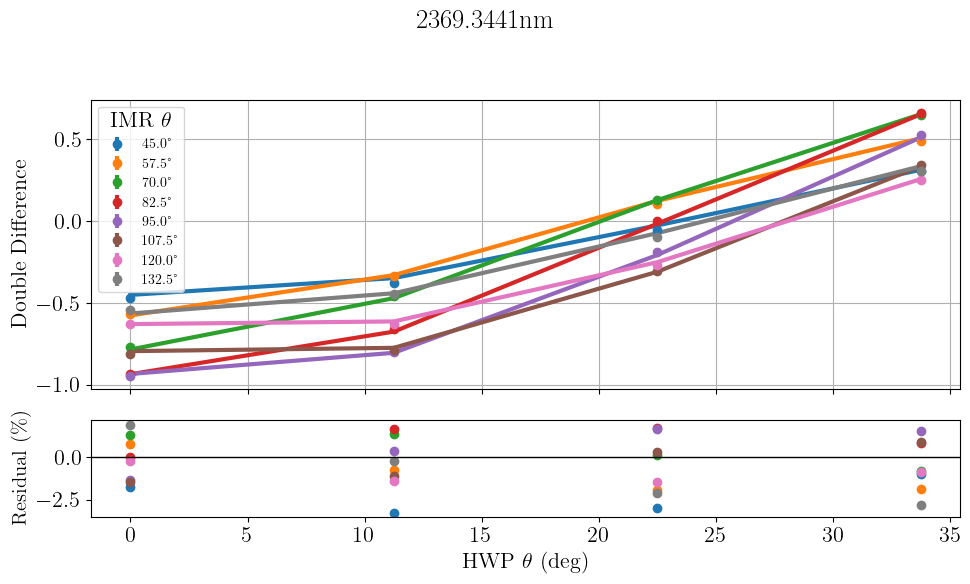

Updated Mueller Matrix:
[[ 0.18465227  0.18465069 -0.00076283  0.        ]
 [-0.17404062 -0.17403913  0.00071899  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
s_res: 1.6170781397939733
Residuals range: -3.2583734021422117 1.930962082267861
Error: [0.00030614 0.02779378 0.0285977  0.        ]


In [3]:
# Fit all 22 wavelength bins
errors = []
sres_list = []
for bin in range(0,22):
    error,fig,ax,sres = fit_CHARIS_Mueller_matrix_by_bin_pickoff(
        Path(f'datacsvs/csvs_pickoff/bin{bin}_pick.csv'),
        bin,
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/elliptical_imr_pickoff/bin{bin}.json')
        
    )
    errors.append(error)
    sres_list.append(sres)


In [3]:
errors = np.array(errors)
print('imr_ret', np.mean(errors[:,0]))
print('imr_off',np.mean(errors[:,1]))
print('hwp_ret',np.mean(errors[:,2]))
print('hwp_off',np.mean(errors[:,3]))

imr_ret nan
imr_off 66925.94679049187
hwp_ret 1607.8699655796072
hwp_off nan


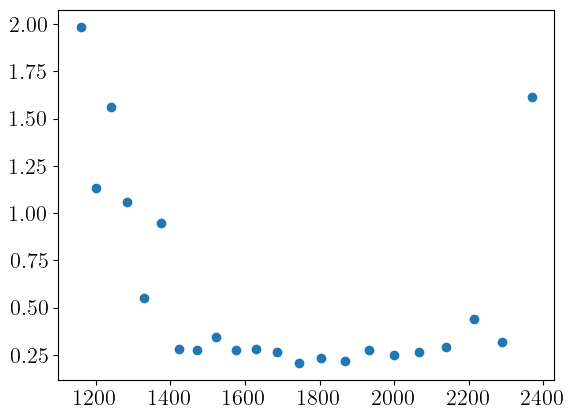

In [ ]:
from vampires_calibration.constants import wavelength_bins
# pickoff as general diattenuator and ellipctical retarder
plt.scatter(wavelength_bins, sres_list)

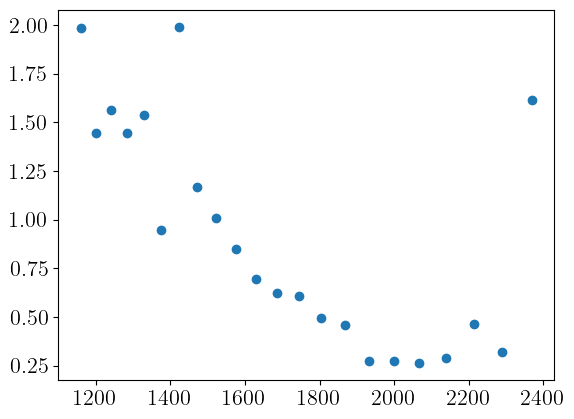

In [4]:
from vampires_calibration.constants import wavelength_bins
# pickoff as linear retarder
plt.scatter(wavelength_bins, sres_list)

In [5]:
from vampires_calibration.csv_tools import model_data
df = model_data('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/elliptical_imr_pickoff')
df

,wavelength_bin,pickoff_T_avg,pickoff_d_45,pickoff_d_h,pickoff_d_r,pickoff_delta_theta,pickoff_ret_delta_theta,pickoff_ret_phi_45,pickoff_ret_phi_h,pickoff_ret_phi_r
0,1159.5614,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,0.000000,0.000000,1.000000e-10,1.000000e-10,1.000000e-10
1,1199.6971,1.579524e-03,1.207247e-01,3.664630e-02,6.373448e-19,-0.195377,44.916980,3.373833e+00,2.500505e-03,1.120288e-04
2,1241.2219,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,0.000000,0.000000,1.000000e-10,1.000000e-10,1.000000e-10
3,1284.1840,2.233166e-01,1.448667e-01,7.722194e-02,1.000000e-10,1.275907,44.861360,1.572806e+00,9.935156e-05,4.278097e-09
4,1328.6331,2.509719e-04,3.804664e-11,6.292274e-02,1.045490e-01,-7.117544,-5.516263,5.045603e-03,8.968944e-01,7.877494e-02
5,1374.6208,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,0.000000,0.000000,1.000000e-10,1.000000e-10,1.000000e-10
6,1422.2002,1.030248e-02,2.128061e-04,9.723487e-02,2.121453e-13,-15.021697,-0.016588,1.771950e-02,6.508111e-04,3.864621e-03
7,1471.4264,4.470916e-02,2.315651e-06,8.187379e-02,5.820192e-02,-17.806811,1.690004,1.741558e-02,9.007685e-03,4.797276e-03
8,1522.3565,3.550241e-05,1.171609e-06,7.465922e-02,4.099604e-02,-11.543754,-0.009661,1.744002e-02,6.015818e-02,6.331639e-03
9,1575.0495,5.882248e-05,2.916822e-10,6.931317e-02,2.020364e-02,-12.213255,0.062353,1.301315e-02,5.600990e-03,7.481590e-03


In [4]:
avg_pick_delta_theta = np.mean(df['pickoff_delta_theta'])
avg_pick_delta_theta

21.943616036225393

(array([5.00000000e-13, 5.00000000e-13, 5.75021932e-13, 9.53886575e-10,
        5.97250499e-01, 4.60279604e-01, 4.49114419e-01, 3.30253738e-01,
        1.60103336e-01, 5.00680869e-13, 5.04429712e-13, 5.00000000e-13,
        5.00395663e-13, 8.11137770e-01, 8.28438588e-01, 8.35174452e-01,
        8.41363531e-01, 8.46217597e-01, 8.43375449e-01, 8.36454547e-01,
        8.26963054e-01, 8.14032734e-01]),
 <Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'pickoff: epsilon vs wavelength'}, xlabel='Wavelength (nm)', ylabel='epsilon'>)

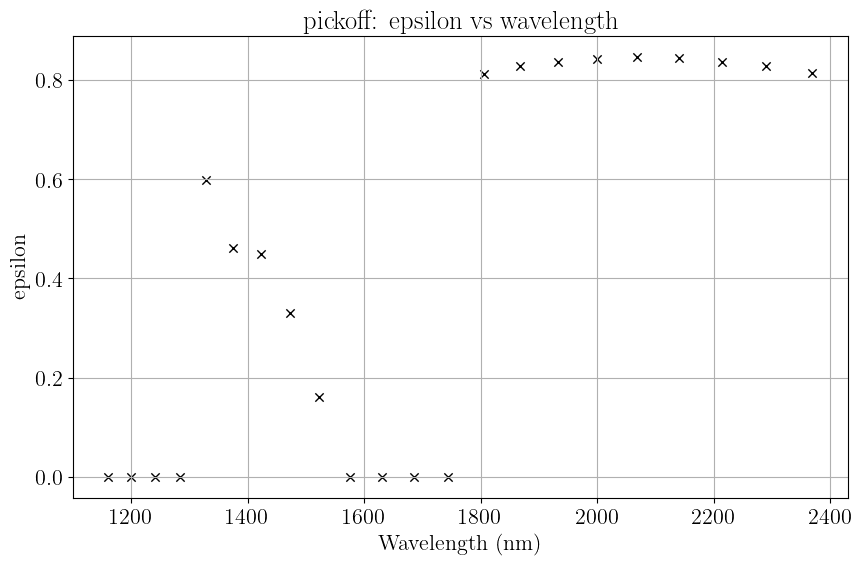

In [7]:
from vampires_calibration.plotting import plot_config_dict_vs_wavelength
jsondir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_no_pickoff_extra_eps')
plot_config_dict_vs_wavelength('pickoff','epsilon',jsondir)

In [4]:
# find average error
errors = np.array(errors)
print('pickoff_ret', np.mean(errors[:,0]))
print('pickoff_offset',np.mean(errors[:,1]))



    

pickoff_ret 0.8591047254114081
pickoff_offset 25.11930543197441


In [7]:
# Now let's make a dataframe of our data, this model data function can be changed easily to include
# whatever parameters you're fitting
from vampires_calibration.plotting import model_data
json_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets'
df = model_data(json_dir)
df

,wavelength_bin,pickphi,pickoffoff
0,1159.5614,0.081807,5.000000
1,1199.6971,0.194780,5.000000
2,1241.2219,0.235090,5.000000
3,1284.1840,0.216184,5.000000
4,1328.6331,0.959240,-3.395535
5,1374.6208,0.683815,-3.252282
6,1422.2002,2.588989,-0.450526
7,1471.4264,2.373945,-0.312329
8,1522.3565,1.130781,-0.268333
9,1575.0495,0.065208,-5.000000


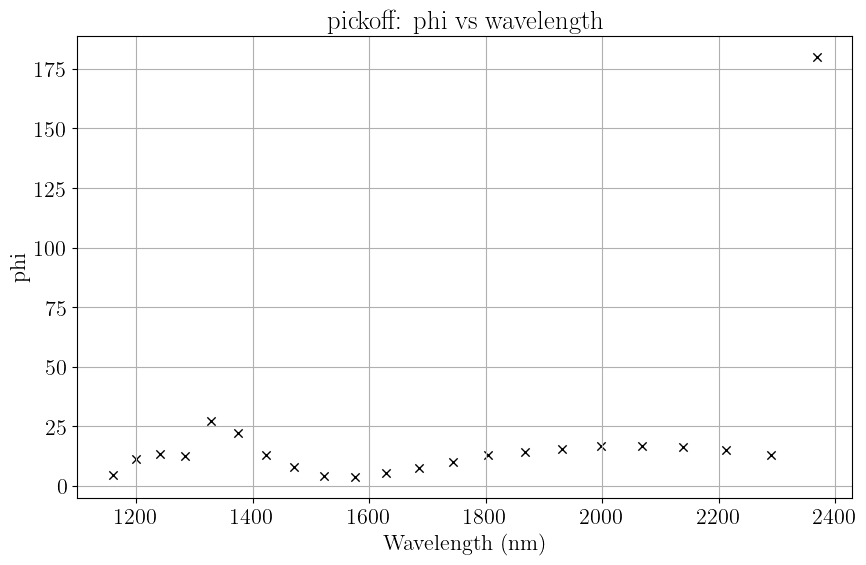

In [6]:
from vampires_calibration.plotting import plot_config_dict_vs_wavelength
params,fig_pick, ax_pick = plot_config_dict_vs_wavelength('pickoff','phi','/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets')

# Step 4: Refine Retardance Model

This step depends heavily on what components you are fitting to. I'm going to make the IMR and HWP retardances a function of wavelength using the Joost t Hart 2021 physical models. I'll use the parameters we just fitted as my dataset. 

In [11]:
def phys_model_chisq(p0, wavelengths, retardances_hwp, errors_hwp, retardances_imr,errors_imr):
    """
    Calculate the chi squared for the physical model of CHARIS.
    
    Parameters:
    -----------
    p0 : list
        List of parameters [w_sio2, w_mgf2, d].
    
    wavelengths : numpy array
        Array of wavelengths that are in the data.

    retardances_hwp : list or numpy array
        Retardances of the HWP at the specified wavelengths.

    errors_hwp : list or numpy array
        Errors associated with the HWP retardances.

    retardances_imr : list or numpy array
        Retardances of the IMR at the specified wavelengths.
    
    errors_imr : list or numpy array
        Errors associated with the IMR retardances.
    
    Returns:
    --------
    float
        The chi squared value.
    """
    # Get model retardances
    model_hwp = HWP_retardance(wavelengths, p0[0], p0[1])
    model_imr = IMR_retardance(wavelengths, p0[2])
    # Calculate residuals
    residuals_hwp = (retardances_hwp - model_hwp) / errors_hwp
    residuals_imr = (retardances_imr - model_imr) / errors_imr
    # Calculate log-likelihood
    chisq_hwp = np.sum(residuals_hwp**2)
    chisq_imr = np.sum(residuals_imr**2)
    return chisq_hwp + chisq_imr

In [12]:

# Minimizing the physical model

p0 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021
wavelengths = wavelength_bins # CHARIS wavelength bins

# Defining reasonable bounds (these values shouldn't have changed much)
  
wsio2_bounds = (0.9*p0[0], 1.1*p0[0])
wmgf2_bounds = (0.9*p0[1], 1.1*p0[1])
d_bounds = (0.9*p0[2], 1.1*p0[2])
bounds = [wsio2_bounds, wmgf2_bounds, d_bounds]

# Extract our retardances and errors from the data
errors = np.array(errors)
hwp_retardances = df['hwp_retardance'].values
imr_retardance = df['imr_retardance'].values
hwp_errors = errors[:,0] 
imr_errors = errors[:,1]  

# Use a while loop to iteratively minimize the chi squared function
# Counters for iterative fitting

iteration = 1
previous_chisq = 1000000
new_chisq = 0

while abs(previous_chisq-new_chisq)> 0.01*abs(previous_chisq):
        previous_chisq = new_chisq
        result = minimize(phys_model_chisq,p0, args=(wavelengths, hwp_retardances, hwp_errors, imr_retardance, imr_errors), bounds=bounds)
        p0 = result.x
        new_chisq = result.fun
        iteration += 1
        print(result)

hess_inv = result.hess_inv


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2437.668321379841
        x: [ 1.663e+00  1.298e+00  2.584e+02]
      nit: 8
      jac: [ 4.302e+00 -5.756e+00 -2.547e-03]
     nfev: 80
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2437.6683213792157
        x: [ 1.663e+00  1.298e+00  2.584e+02]
      nit: 1
      jac: [ 9.732e-03  1.055e-02 -1.546e-03]
     nfev: 12
     njev: 3
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


That's It! The fit is updated. However, in the Hart 2021 paper, a degeneracy in wavelength bin 4 was noted. Because of this, I will redo the fit to see if the model fits better. 

In [13]:
# Redo the fit without the degenerate point (bin 4)

wavelengths2 = np.delete(wavelength_bins, 4)
p0_2 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021

# Defining reasonable bounds (these values shouldn't have changed much)

wsio2_bounds2 = (0.9*p0_2[0], 1.1*p0_2[0])
wmgf2_bounds2 = (0.9*p0_2[1], 1.1*p0_2[1])
d_bounds2 = (0.9*p0_2[2], 1.1*p0_2[2])
bounds2 = [wsio2_bounds2, wmgf2_bounds2, d_bounds2]

# Extract our retardances and errors from the data
errors2 = np.delete(np.array(errors), 4, axis=0)
hwp_retardances2 = df['hwp_retardance'].values
imr_retardance2 = df['imr_retardance'].values
hwp_errors2 = errors2[:,0] 
imr_errors2 = errors2[:,1]  

# Remove the corresponding retardances for the removed bin

hwp_retardances2 = np.delete(hwp_retardances2, 4)
imr_retardance2= np.delete(imr_retardance2,4)

# Use a while loop to iteratively minimize the chi squared function

# Counters for iterative fitting

iteration2 = 1
previous_logl2 = 1000000
new_logl2 = 0

while abs(previous_logl2-new_logl2)> 0.01*abs(previous_logl2):
        previous_logl2 = new_logl2
        result2 = minimize(phys_model_chisq,p0_2, args=(wavelengths2, hwp_retardances2, hwp_errors2, imr_retardance2, imr_errors2), bounds=bounds2)
        p0_2 = result2.x
        new_logl2 = result2.fun
        iteration2 += 1
        print(result2)






  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 2126.5886920305
        x: [ 1.665e+00  1.300e+00  2.584e+02]
      nit: 7
      jac: [ 1.847e+00 -2.465e+00 -3.956e-03]
     nfev: 160
     njev: 40
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 2126.5886920305
        x: [ 1.665e+00  1.300e+00  2.584e+02]
      nit: 0
      jac: [ 1.847e+00 -2.465e+00 -3.956e-03]
     nfev: 52
     njev: 13
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [14]:
# Compare chi sq of all models

p0_Hart = [1.623, 1.268, 262.56]

# Hart chi sq

print("Hart:",phys_model_chisq(p0_Hart,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model with all bins

print("Our model with all bins:",phys_model_chisq(result.x,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model without bin 4

print("Our model without bin 4:",phys_model_chisq(result2.x,wavelengths2, hwp_retardances2,hwp_errors2,imr_retardance2,imr_errors2))



Hart: 8447.5197089818
Our model with all bins: 2437.6683213792157
Our model without bin 4: 2126.588692030502


In [13]:
print(1.268*1.2)

1.5216


# Step 5: Fit for Offsets Globally

In [31]:
# Get interleaved values for all wavelength bins
from vampires_calibration.constants import wavelength_bins
csvdir = Path('datacsvs/csvs_nopickoff')

interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csvdir)


wavelength_bin = 15 # placeholder
epsilon_cal = 1 # defining as perfect, reasoning in Joost t Hart 2021
offset_imr = -0.0018
offset_hwp = -0.0022 
offset_cal = -0.0315 
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
d = 258.3
wsio2 = 1.667
wmgf2 = 1.301

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "wollaston_prism_function",
        "properties" : {"beam": 'o'}, 
        "tag": "internal",
    },
    "pickoff" : {
        "type" : "general_retarder_function",
        "properties" : {"phi": 0, "delta_theta":0 },
        "tag": "internal",
},      
    "image_rotator" : {
        "type" : "SCExAO_IMR_function",
        "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": d, "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "two_layer_HWP_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lprot": { # changed from delta_theta to match Joost t Hart
        "type": "rotator_function",
        "properties" : {'pa':offset_cal},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal},
        "tag": "internal",
    }}
}
    
# Starting guesses


p0_dict = {
    "image_rotator" : 
        {"d": d, "delta_theta": 0},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": 0},
    "lprot" : 
        {"pa": 0},
}

system_mm = generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM

p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5,5) 
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.8*p0[0], 1.2*p0[0])
wmgf2_bounds = (0.8*p0[1], 1.2*p0[1])
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
# Process everything into double differences and propagate errors




In [33]:
# Minimize everything globally with minimize

result_min, logl_min=minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds],mode='minimize')
print(result_min)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 454264366.20675933
        x: [ 2.648e+02 -3.637e-01  1.720e+00  1.340e+00 -1.581e+00
            -3.349e-01]
      nit: 47
      jac: [ 3.664e+04 -4.134e+05  2.219e+05  5.962e+04  3.152e+05
            -3.242e+05]
     nfev: 378
     njev: 54
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [26]:
# Minimize everything globally with least squares
    # Counters for iterative fitting

iteration = 1
previous_logl = 1000000
new_logl = 0

    # Perform iterative fitting
    # MODIFY THE BOUNDS INPUT HERE IF YOU WANT TO CHANGE PARAMETERS
while abs(previous_logl - new_logl) > 0.01*abs(previous_logl):
    if iteration > 1:
        previous_logl = new_logl
    # Configuring minimization function for CHARIS
    result, new_logl, error = minimize_system_mueller_matrix(p0_dict, system_mm, interleaved_values_all, 
        interleaved_stds_all, configuration_list_all, process_dataset=process_dataset,process_model=process_model,process_errors=process_errors,include_sums=False, bounds = bounds,mode='least_squares')
    print(result)

    # Update p0 with new values

    update_p0(p0_dict, result.x)
    iteration += 1

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0580e+09                                    6.31e+09    
       1              2         4.9331e+08      5.65e+08       5.19e+00       7.08e+08    
       2              3         4.5650e+08      3.68e+07       1.32e+00       4.85e+08    
       3              4         4.5509e+08      1.41e+06       3.94e-01       1.14e+08    
       4              5         4.5327e+08      1.82e+06       2.60e+00       3.70e+08    
       5              6         4.5178e+08      1.49e+06       2.74e+00       5.17e+08    
       6              7         4.5112e+08      6.60e+05       1.13e+00       3.89e+08    
       7              8         4.5094e+08      1.83e+05       2.25e-02       1.32e+08    
       8              9         4.5072e+08      2.18e+05       1.65e-02       7.39e+07    
       9             10         4.5047e+08      2.46e+05       1.87e-02       6.34e+07    

In [18]:
# Constrain offsets more
offset_bounds2 = (-1,1)
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
result2, logl2,error2 = minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds2,wsio2_bounds,wmgf2_bounds,offset_bounds2,offset_bounds2],mode='least_squares')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0580e+09                                    6.31e+09    
       1              2         5.9708e+08      4.61e+08       5.05e+00       5.00e+08    
       2              3         5.0370e+08      9.34e+07       1.29e+00       5.14e+08    
       3              4         4.7468e+08      2.90e+07       3.67e-01       3.00e+08    
       4              5         4.6572e+08      8.96e+06       1.38e-01       1.58e+08    
       5              6         4.6318e+08      2.54e+06       4.61e-02       8.00e+07    
       6              7         4.6271e+08      4.66e+05       1.22e-02       4.67e+07    
       7              8         4.6260e+08      1.13e+05       1.26e-02       3.95e+07    
       8              9         4.6253e+08      6.61e+04       1.09e-02       3.37e+07    
       9             10         4.6249e+08      3.84e+04       8.82e-03       2.79e+07    

In [27]:
print(result.x)
print(result.cost)

[264.42562781  -0.39365267   1.58686793   1.24095445  -4.23357352
   5.        ]
449884920.39102626


In [22]:
print(result2.x)
print(result2.cost)
print(error2)

[ 2.64817320e+02 -1.39181363e-01  1.71139669e+00  1.33335800e+00
 -1.00000000e+00 -1.00000000e+00]
462453907.8514557
[0.29609162 0.09746397 0.03290138 0.02418255 1.12956612 2.25189236]


In [ ]:


offset_imr2 = 0.13214 # derotator offset
offset_hwp2 = -0.99287 # HWP offset
offset_cal2 = 0.49797 # calibration polarizer offset


# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm2 = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

